This notebook experiments with the various hyperparamters in the models using surprise library and also compares the different models based on RMSE and MAE.

In [ ]:
!pip install surprise

In [ ]:
from surprise import SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
import time
import pandas as pd

In [ ]:
def convert_traintest_dataframe_forsurprise(training_dataframe, testing_dataframe):
    reader = Reader(rating_scale=(0, 5))
    trainset = Dataset.load_from_df(training_dataframe[['userId', 'movieId', 'rating']], reader)
    testset = Dataset.load_from_df(testing_dataframe[['userId', 'movieId', 'rating']], reader)
    trainset = trainset.construct_trainset(trainset.raw_ratings)
    testset = testset.construct_testset(testset.raw_ratings)
    return trainset, testset

In [ ]:
file_path_train = 'training_data.csv'
file_path_test = 'testing_data.csv'
traindf = pd.read_csv(file_path_train)
testdf = pd.read_csv(file_path_test)
trainset, testset = convert_traintest_dataframe_forsurprise(traindf, testdf)

In [ ]:
def recommendation(algo, trainset, testset):
  # Train the algorithm on the trainset, and predict ratings for the testset
  start_fit = time.time()
  algo.fit(trainset)
  end_fit = time.time()
  fit_time = end_fit - start_fit

  # Predictions on testing set
  start_test = time.time()
  test_predictions = algo.test(testset)
  end_test = time.time()
  test_time = end_test - start_test

  test_rmse = accuracy.rmse(test_predictions)
  test_mae = accuracy.mae(test_predictions)
  
  return test_rmse, test_mae, test_predictions, fit_time, test_time

#### Basic algorithm (Baseline approach):

In [ ]:
algo = BaselineOnly()

test_rmse, test_mae, test_predictions, fit_time, test_time = recommendation(algo,trainset,testset)
print(fit_time)
print(test_time)

Estimating biases using als...
RMSE: 0.8735
MAE:  0.6718
0.16143345832824707
0.15967273712158203


#### Matrix Factorization-based algorithms:

In [ ]:
# algorithm is equivalent to Probabilistic Matrix Factorization [check]

algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

RMSE: 0.8766
MAE:  0.6716
Done!


In [ ]:
# algorithm is an extension of SVD that takes into account implicit ratings.

algo = SVDpp()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

RMSE: 0.8647
MAE:  0.6606
Done!


In [ ]:
# collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

algo = NMF()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")  

RMSE: 0.9271
MAE:  0.7087
Done!


#### k-NN algorithms (Collabrative filtering) :

Note: KNNBaseline() seems to be giving the best result in KNN approaches

In [ ]:
# Basic collaborative filtering algo

algo = KNNBasic()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9272
MAE:  0.7310
Done!


In [ ]:
# basic collaborative filtering algorithm taking into account a baseline rating.

algo = KNNBaseline()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8978
MAE:  0.7081
Done!


In [ ]:
# Basic collaborative filtering algorithm, taking into account the mean ratings of each user

algo = KNNWithMeans()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9316
MAE:  0.7398
Done!


In [ ]:
# basic collaborative filtering algorithm, taking into account the z-score normalization of each user

algo = KNNWithZScore()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9324
MAE:  0.7375
Done!


In [ ]:
# collaborative filtering algorithm based on co-clustering. 

algo = Coclustering()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

##### Fine Tuning Hyperparameters:

In [ ]:
from surprise import NormalPredictor
from surprise.model_selection import GridSearchCV

1. SVD and SVDpp

In [ ]:
# param_grid = {'n_factors':[50,100,150],'n_epochs':[20,30],  'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}

param_grid = {'n_factors':[25,50,100], 'n_epochs': [5, 10, 20], 'lr_all': [0.01, 0.02],
              'reg_all': [0.01,0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

AttributeError: ignored

In [ ]:
# best RMSE score
print(gs.best_score['mae'])

0.6831594224152958


2. Chaning number of neighbors for KNN

In [ ]:
param_grid = {'k': [15, 20, 25, 30, 40, 50, 60]}

knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnbasic_gs.fit(data)

knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs.fit(data)

knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs.fit(data)

knnbaseline_gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnbaseline_gs.fit(data)

In [ ]:
knnbasic_gs.best_params['rmse']

{'k': 60}

In [ ]:
x = [15, 20, 25, 30, 40, 50, 60]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

y7 = knnbaseline_gs.cv_results['mean_test_rmse']
y8 = knnbaseline_gs.cv_results['mean_test_mae']

In [ ]:
import matplotlib.pyplot as plt

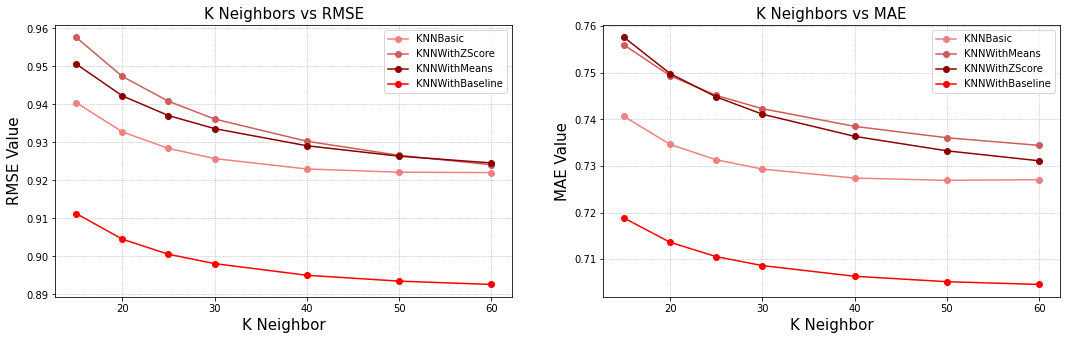

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')
plt.plot(x, y7, label='KNNWithBaseline', color='red', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.plot(x, y8, label='KNNWithBaseline', color='red', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()

3. Plotting for all the Algorithms

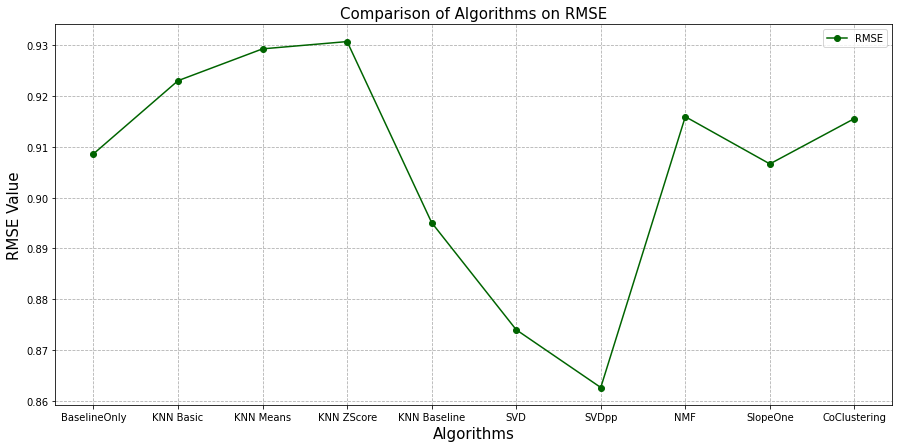

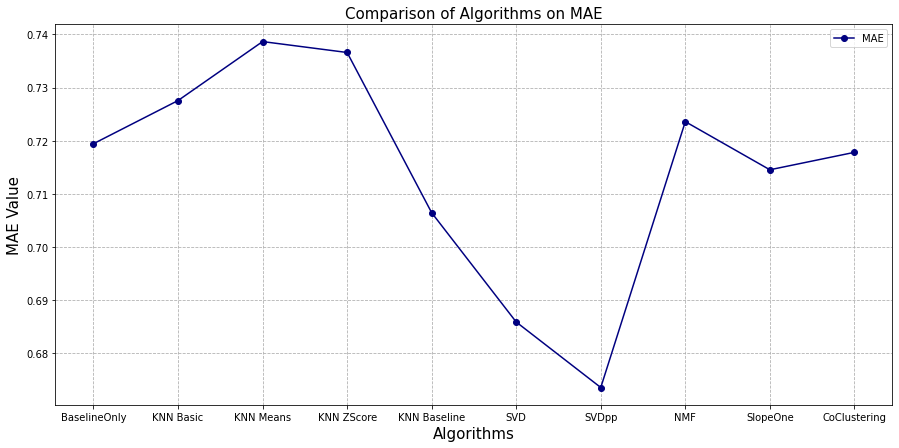

In [ ]:
x_algo = ['BaselineOnly','KNN Basic', 'KNN Means', 'KNN ZScore','KNN Baseline', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']


rmse = [0.908617, 0.923024, 0.929287, 0.930720,0.895069,0.873984,0.862614,0.915935, 0.906634,0.915561]
mae = [0.719422, 0.727552,0.738663,0.736607,0.706415,0.685826,0.673489,0.723579, 0.714510,0.717795]
fit_time = [4.586215, 56.279947, 57.593617,54.722606,62.627911,55.877482,3256.132195,55.372593,16.042697, 19.347667]
test_time = [2.908219, 150.852565, 163.850462,161.066698,174.428705,2.632710,73.504739,2.918873, 64.904856,2.986175 ]

plt.figure(figsize=(15,7))

# plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()

# plt.subplot(1, 2, 2)
plt.figure(figsize=(15,7))
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

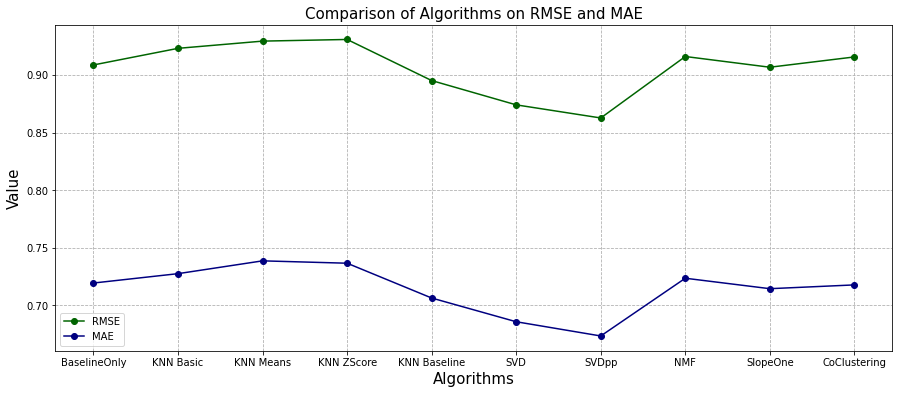

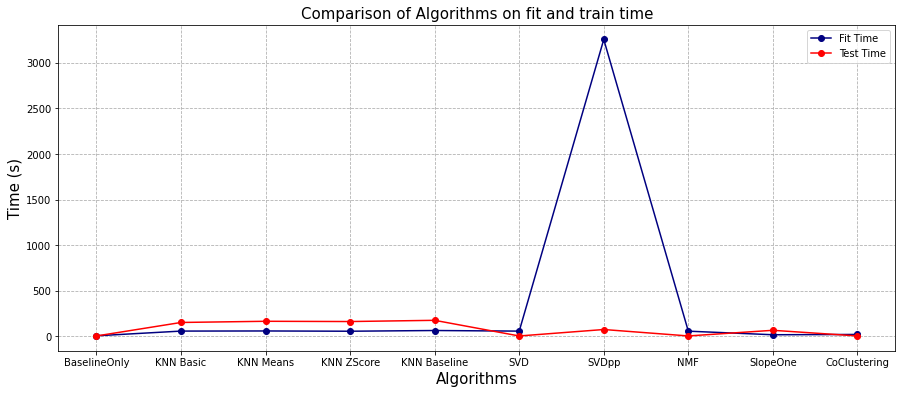

In [ ]:
x_algo = ['BaselineOnly','KNN Basic', 'KNN Means', 'KNN ZScore','KNN Baseline', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']

rmse = [0.908617, 0.923024, 0.929287, 0.930720,0.895069,0.873984,0.862614,0.915935, 0.906634,0.915561]
mae = [0.719422, 0.727552,0.738663,0.736607,0.706415,0.685826,0.673489,0.723579, 0.714510,0.717795]
fit_time = [4.586215, 56.279947, 57.593617,54.722606,62.627911,55.877482,3256.132195,55.372593,16.042697, 19.347667]   # 3256.132195
test_time = [2.908219, 150.852565, 163.850462,161.066698,174.428705,2.632710,73.504739,2.918873, 64.904856,2.986175 ]

plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on RMSE and MAE', loc='center', fontsize=15)
plt.plot(x_algo, rmse, label='RMSE', color='darkgreen', marker='o')
plt.plot(x_algo, mae, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()

# plt.figure(figsize=(15,6))
# plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
# plt.plot(x_algo, mae, label='MAE', color='navy', marker='o')
# plt.xlabel('Algorithms', fontsize=15)
# plt.ylabel('MAE Value', fontsize=15)
# plt.legend()
# plt.grid(ls='dashed')
# plt.show()

plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on fit and train time', loc='center', fontsize=15)
plt.plot(x_algo, fit_time, label='Fit Time', color='navy', marker='o')
plt.plot(x_algo, test_time, label='Test Time', color='red', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Time (s)', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()

RMSE vs MAE (with Pearson Baseline)

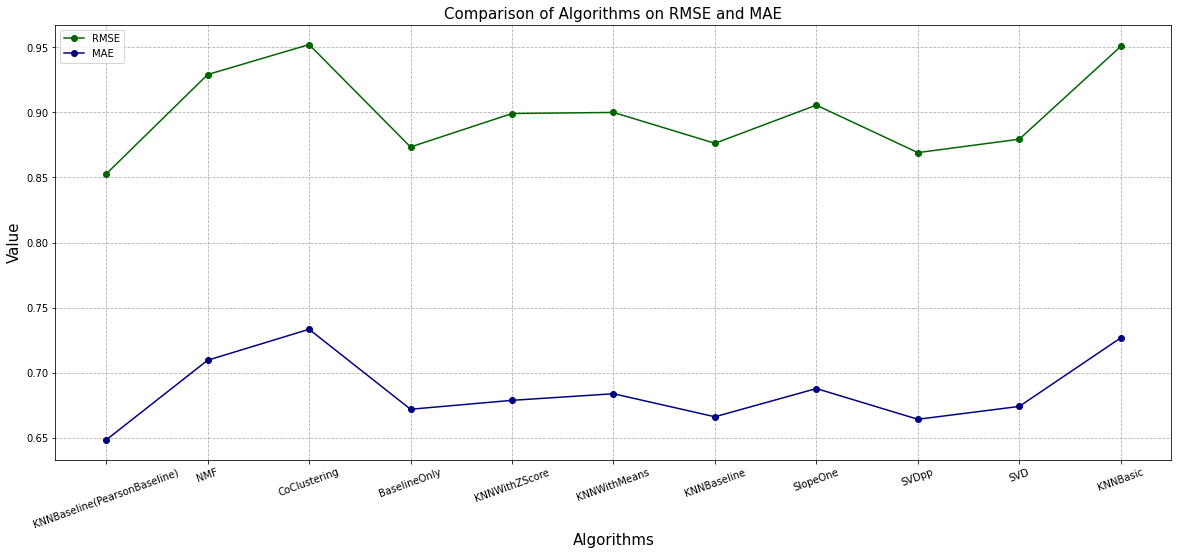

In [ ]:
x_algo = ['KNNBaseline(PearsonBaseline)', 'NMF', 'CoClustering' , 'BaselineOnly',  'KNNWithZScore', 'KNNWithMeans', 'KNNBaseline',  'SlopeOne', 'SVDpp', 'SVD', 'KNNBasic']

rmse = [0.852704841,0.929141887, 0.952207693, 0.873457272, 0.899184082, 0.900034458, 0.876293478,  0.905644659, 0.869118649, 0.879436485, 0.950772481]
mae = [0.648183105,0.709469416, 0.733263706, 0.671769591, 0.678622725, 0.683693287, 0.665991827,  0.687691908, 0.664051387, 0.673949332, 0.72665254]

plt.figure(figsize=(20,8))
plt.title('Comparison of Algorithms on RMSE and MAE', loc='center', fontsize=15)
plt.plot(x_algo, rmse, label='RMSE', color='darkgreen', marker='o')
plt.plot(x_algo, mae, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.xticks(rotation=20)
plt.ylabel('Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()

Evaluation Parameters (with Peason Baseline)

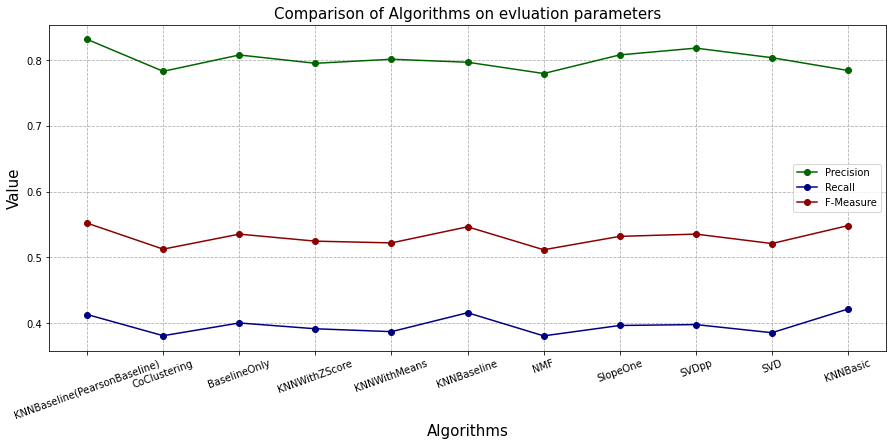

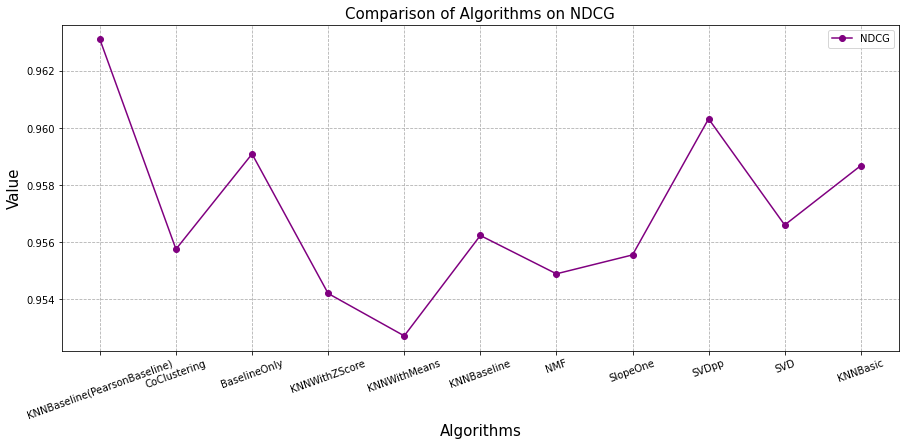

In [ ]:
x_algo = ['KNNBaseline(PearsonBaseline)', 'CoClustering' , 'BaselineOnly',  'KNNWithZScore', 'KNNWithMeans', 'KNNBaseline', 'NMF', 'SlopeOne', 'SVDpp', 'SVD', 'KNNBasic']

precision = [0.831174863, 0.782622951, 0.807431694, 0.794808743, 0.800956284, 0.796420765, 0.779289617, 0.807540984, 0.81784153 , 0.803306011, 0.783879781]
recall = [0.41316939, 0.380981011, 0.400350057, 0.391524914, 0.387139403, 0.415881052, 0.380744697, 0.396525008, 0.397884087, 0.385541576, 0.421534995]
f_measure = [0.551963028, 0.512484475, 0.535287645, 0.52462041, 0.521981085, 0.546425487, 0.511554504, 0.53188147, 0.535328245, 0.521021986, 0.548247402]
ndcg = [0.963102331, 0.955747856, 0.959085417, 0.954195102, 0.952709341, 0.956227561, 0.954884102, 0.95554646, 0.960316623, 0.95659579, 0.958675746]

plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on evluation parameters', loc='center', fontsize=15)
plt.plot(x_algo, precision, label='Precision', color='darkgreen', marker='o')
plt.plot(x_algo, recall, label='Recall', color='navy', marker='o')
plt.plot(x_algo, f_measure, label='F-Measure', color='darkred', marker='o')
# plt.plot(x_algo, ndcg, label='NDCG', color='purple', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.xticks(rotation=20)
plt.ylabel('Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()


plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on NDCG', loc='center', fontsize=15)
plt.plot(x_algo, ndcg, label='NDCG', color='purple', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.xticks(rotation=20)
plt.legend()
plt.grid(ls='dashed')
plt.show()